In [201]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import json
import seaborn as sns

## Data Preparation & Preprocessing

In [178]:
# Set seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)  # Set seed for numpy
    random.seed(seed)  # Set seed for random
    
    if torch.cuda.is_available():
        torch.manual_seed(seed)  # Set seed for PyTorch CPU
    
    torch.cuda.manual_seed(seed)  # Set seed for PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # Set seed for all GPUs
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CUDA
    torch.backends.cudnn.benchmark = False  # Disable the auto-tuner for GPUs

set_seed(42)

In [179]:
# Load hyperparameters
with open('configs/configs.json', 'r') as file:
    hyperparams = json.load(file)

In [180]:
# Remove outliers from data
def remove_outliers(data):
    # Convert data to a numpy array if it isn't already
    data = np.array(data)

    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    # Calculate the IQR (Interquartile Range)
    IQR = Q3 - Q1

    # Define the acceptable range for non-outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    
    return filtered_data.tolist()

In [181]:
# Load the data
def load_data(file):
    # Load the data
    data = pd.read_csv('data/' + file + '.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Round to 2 decimal places
    data = data.round(2) 

    return data

In [185]:
# Create sequences
def create_sequences(data, input_size, num_steps, val_split=0.2, test_split=0.1):
    data = [np.array(data[i * input_size: (i + 1) * input_size]) 
       for i in range(len(data) // input_size)]

    # Normalize
    data = [data[0] / data[0][0] - 1.0] + [
                curr / data[i][-1] - 1.0 for i, curr in enumerate(data[1:])]

    print(np.array(data).shape)
    
    # Split into groups of `num_steps`
    X = np.array([data[i: i + num_steps] for i in range(len(data) - num_steps)])
    y = np.array([data[i + num_steps] for i in range(len(data) - num_steps)])

    # Reshape X to have shape (N, num_steps, input_size)
    X = X.reshape(-1, num_steps, input_size)
    y = y.reshape(-1, input_size)  # Reshape y to match the output shape

    # Split into train, validation, and test sets
    total_len = len(X)
    test_start = int(total_len * (1 - test_split))
    val_start = int(total_len * (1 - test_split - val_split))
    
    X_train, X_val, X_test = X[:val_start], X[val_start:test_start], X[test_start:]
    y_train, y_val, y_test = y[:val_start], y[val_start:test_start], y[test_start:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Extract attributes
num_steps = hyperparams['num_steps']  # Extract number of steps
input_size = hyperparams['input_size']  # Extract input size
val_split = hyperparams['val_split']  # Extract validation split
test_split = hyperparams['test_split']  # Extract test split

data = load_data('SP500')[['Close']]
X_train, y_train, X_val, y_val, X_test, y_test = create_sequences(data, input_size, num_steps, val_split, test_split)

(5659, 3, 1)


In [141]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

assert(not torch.isnan(X_train_tensor).any())
assert(not torch.isnan(y_train_tensor).any())
assert(not torch.isnan(X_val_tensor).any())
assert(not torch.isnan(y_val_tensor).any())
assert(not torch.isnan(X_test_tensor).any())
assert(not torch.isnan(y_test_tensor).any())

In [142]:
# Create DataLoader instances
batch_size = hyperparams['batch_size']
num_workers = hyperparams['num_workers']  # Extract number of workers from hyperparameters

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

## Model Definition: LSTM Cell

In [143]:
# Extract hyperparameters
def extract_hyperparams(hyperparams, model):
    num_units = hyperparams[model][model + '_units']
    num_layers = hyperparams[model][model + '_layers']
    dropout_rate = hyperparams[model]['dropout_rate']
    dense_units = hyperparams[model]['dense_units']
    init_learning_rate = hyperparams[model]['init_learning_rate']
    learning_rate_decay = hyperparams[model]['learning_rate_decay']
    init_epochs = hyperparams[model]['init_epochs']
    max_epochs = hyperparams[model]['max_epochs']
    use_early_stop = hyperparams[model]['use_early_stop']
    early_stop_patience = hyperparams[model]['early_stop_patience']
    train_needed = hyperparams[model]['pretrain'] # Whether to train the model

    return num_units, num_layers, dropout_rate, dense_units, init_learning_rate, learning_rate_decay, init_epochs, max_epochs, use_early_stop, early_stop_patience, train_needed

num_units, num_layers, dropout_rate, dense_units, init_learning_rate, learning_rate_decay, init_epochs, max_epochs, use_early_stop, early_stop_patience, train_needed = extract_hyperparams(hyperparams, 'lstm')

In [144]:
class CustomLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim

        # Initialize weights and biases
        self.W_i = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_i = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_i = nn.Parameter(torch.zeros(hidden_dim).float())

        self.W_f = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_f = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_f = nn.Parameter(torch.zeros(hidden_dim).float())
        
        self.W_c = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_c = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_c = nn.Parameter(torch.zeros(hidden_dim).float())
        
        self.W_o = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_o = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_o = nn.Parameter(torch.zeros(hidden_dim).float())
        
        # Layer normalization layers
        self.ln_i = nn.LayerNorm(hidden_dim)
        self.ln_f = nn.LayerNorm(hidden_dim)
        self.ln_c = nn.LayerNorm(hidden_dim)
        self.ln_o = nn.LayerNorm(hidden_dim)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.orthogonal_(param)  # Use orthogonal initialization
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)

            # Check for NaN values
            assert(not torch.isnan(param).any())

    def forward(self, x, h, c):
        i_t = torch.sigmoid(self.ln_i(torch.mm(x, self.W_i) + torch.mm(h, self.U_i) + self.b_i))
        f_t = torch.sigmoid(self.ln_f(torch.mm(x, self.W_f) + torch.mm(h, self.U_f) + self.b_f))
        g_t = torch.tanh(self.ln_c(torch.mm(x, self.W_c) + torch.mm(h, self.U_c) + self.b_c))
        o_t = torch.sigmoid(self.ln_o(torch.mm(x, self.W_o) + torch.mm(h, self.U_o) + self.b_o))

        c_t = f_t * c + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        
        assert(not torch.isnan(h_t).any())
        assert(not torch.isnan(c_t).any())
    
        return h_t, c_t

In [145]:
class CustomRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_rate, dense_units, cell_type='lstm'):
        super(CustomRNNModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.cell_type = cell_type

        if cell_type == 'lstm':
            self.layers = nn.ModuleList([CustomLSTMCell(input_dim, hidden_dim)])
            self.layers.extend([CustomLSTMCell(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        elif cell_type == 'gru':
            self.layers = nn.ModuleList([CustomGRUCell(input_dim, hidden_dim)])
            self.layers.extend([CustomGRUCell(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        else:
            raise ValueError("Unsupported cell type")

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_dim, dense_units)
        self.fc2 = nn.Linear(dense_units, output_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        h_t = [torch.zeros(batch_size, self.hidden_dim, device=x.device) for _ in range(self.num_layers)]
        c_t = [torch.zeros(batch_size, self.hidden_dim, device=x.device) for _ in range(self.num_layers)]

        for t in range(seq_len):
            x_t = x[:, t, :]
            for layer in range(self.num_layers):
                if self.cell_type == 'lstm':
                    h_t[layer], c_t[layer] = self.layers[layer](x_t, h_t[layer], c_t[layer])
                else:
                    h_t[layer] = self.layers[layer](x_t, h_t[layer])
                x_t = h_t[layer]

        x = self.dropout(x_t)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [146]:
# Loss definitions 
def quantile_loss(outputs, targets, quantile=0.5):
    errors = targets - outputs
    loss = torch.max((quantile - 1) * errors, quantile * errors)
    return torch.mean(loss)

class HingeLoss(nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()
        
    def forward(self, outputs, targets):
        return torch.mean(torch.clamp(1 - targets * outputs, min=0))

def directional_loss(outputs, targets):
    return torch.mean(torch.abs(torch.sign(outputs) - torch.sign(targets)))

def choose_loss_function(loss):
    if loss == 'huber':  
        criterion = nn.SmoothL1Loss() 
    elif loss == 'mse': 
        criterion = nn.MSELoss()
    elif loss == 'quantile':
        criterion = quantile_loss(quantile=quantile)
    elif loss == 'hinge':
        criterion = HingeLoss()
    elif loss == 'directional':
        criterion = directional_loss()
    else:
        raise ValueError("Unsupported loss function")

    return criterion

In [147]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, init_epochs, num_epochs, init_learning_rate, learning_rate_decay, device, early_stop_patience=None, cell_type='lstm'):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    early_stop_counter = 0

    learning_rates_to_use = [
    init_learning_rate * (
        learning_rate_decay ** max(float(i + 1 - init_epochs), 0.0)
    ) for i in range(num_epochs)]
    
    for epoch in range(num_epochs):
        model.train()
        current_lr = learning_rates_to_use[epoch]
        optimizer = optim.Adam(model.parameters(), lr=current_lr)
        train_loss = 0.0
        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Early stopping
        if early_stop_patience is not None:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                early_stop_counter = 0
                # Save best model
                torch.save(model.state_dict(), f'models/SP500_{cell_type}_model.pth')
            else:
                early_stop_counter += 1
                if early_stop_counter >= early_stop_patience:
                    print("Early stopping triggered")
                    break
    
    return train_losses, val_losses

# Function to load the model
def load_model(model, cell_type, device):
    model_path = f'models/SP500_{cell_type}_model.pth'
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

In [148]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cell_type = 'lstm'
model = CustomRNNModel(input_dim=input_size, hidden_dim=num_units, output_dim=input_size, num_layers=num_layers, dropout_rate=dropout_rate, dense_units=dense_units, cell_type=cell_type).to(device)

if train_needed:
    # loss function
    criterion = choose_loss_function('huber')
    early_stop_patience = hyperparams[cell_type].get('early_stop_patience', None)
    
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, init_epochs, max_epochs, init_learning_rate, learning_rate_decay, device, early_stop_patience, cell_type=cell_type)
else:
    # Load the model
    model.load_state_dict(torch.load(f'models/SP500_{cell_type}_model.pth'))
    print("Model loaded successfully")

100%|███████████████████████████████████████████| 53/53 [00:07<00:00,  7.45it/s]


Epoch 1/10, Train Loss: 0.0154, Val Loss: 0.0107


100%|███████████████████████████████████████████| 53/53 [00:04<00:00, 12.66it/s]


Epoch 2/10, Train Loss: 0.0088, Val Loss: 0.0058


100%|███████████████████████████████████████████| 53/53 [00:04<00:00, 11.63it/s]


Epoch 3/10, Train Loss: 0.0040, Val Loss: 0.0016


100%|███████████████████████████████████████████| 53/53 [00:04<00:00, 11.65it/s]


Epoch 4/10, Train Loss: 0.0010, Val Loss: 0.0004


100%|███████████████████████████████████████████| 53/53 [00:04<00:00, 13.01it/s]


Epoch 5/10, Train Loss: 0.0006, Val Loss: 0.0003


100%|███████████████████████████████████████████| 53/53 [00:04<00:00, 10.88it/s]


Epoch 6/10, Train Loss: 0.0005, Val Loss: 0.0002


100%|███████████████████████████████████████████| 53/53 [00:04<00:00, 10.63it/s]


Epoch 7/10, Train Loss: 0.0004, Val Loss: 0.0002


100%|███████████████████████████████████████████| 53/53 [00:03<00:00, 13.55it/s]


Epoch 8/10, Train Loss: 0.0003, Val Loss: 0.0001


100%|███████████████████████████████████████████| 53/53 [00:03<00:00, 13.56it/s]


Epoch 9/10, Train Loss: 0.0003, Val Loss: 0.0001


100%|███████████████████████████████████████████| 53/53 [00:03<00:00, 13.71it/s]


Epoch 10/10, Train Loss: 0.0003, Val Loss: 0.0001


In [196]:
# Function to make predictions
def make_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())
    return np.array(predictions), np.array(actuals)

# Get predictions and actual values
predictions, actuals = make_predictions(model, test_loader, device)
predictions = predictions.flatten()
actuals = actuals.flatten()

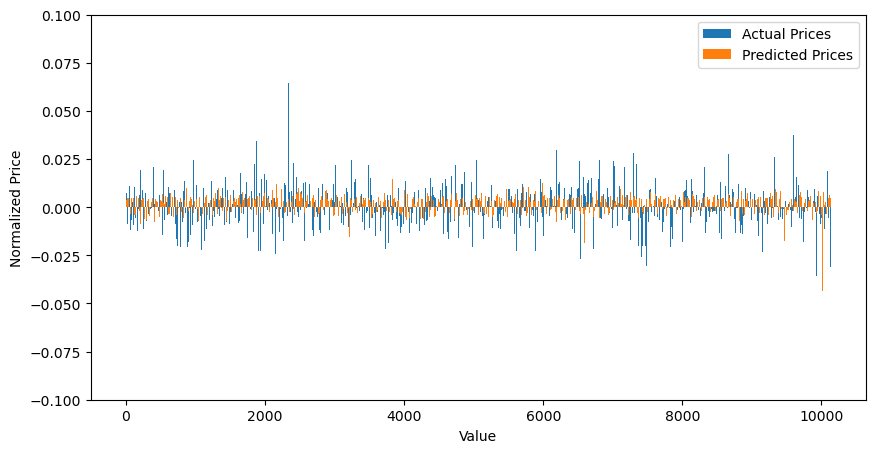

In [221]:
# Plot the predictions against the actual values
plt.figure(figsize=(10, 5))
x = np.arange(len(actuals))
plt.bar(x - 0.2, actuals, label='Actual Prices')
plt.bar(x + 0.2, predictions, label='Predicted Prices')
plt.xlabel('Value')
plt.ylabel('Normalized Price')
plt.ylim(-0.1, 0.1)
plt.legend()
plt.show()

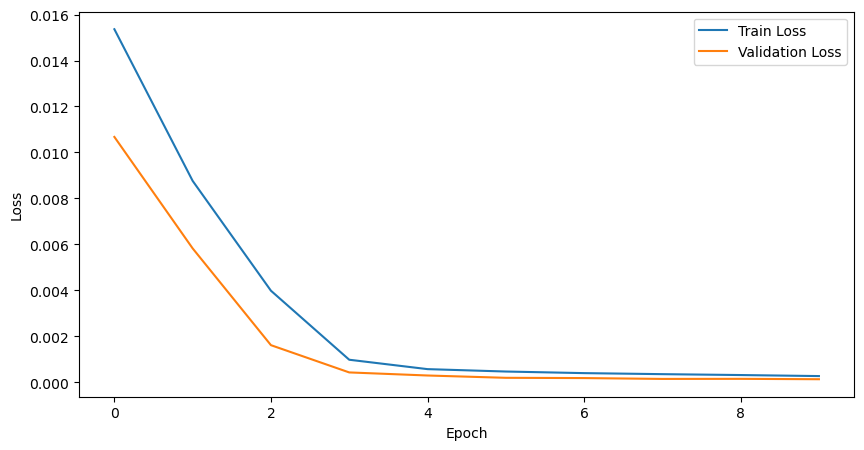

In [222]:
# Check for overfitting/underfitting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [229]:
print("Global classification rate (raise or fall):", np.mean((predictions > 0) == (actuals > 0)))

0.5118941861612871

## Model Definition: GRU Cell

In [252]:
# Extract hyperparams
num_units, num_layers, dropout_rate, dense_units, init_learning_rate, learning_rate_decay, init_epochs, max_epochs, use_early_stop, early_stop_patience, train_needed = extract_hyperparams(hyperparams, 'gru')

In [253]:
class CustomGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomGRUCell, self).__init__()
        self.hidden_dim = hidden_dim

        # Initialize weights and biases
        self.W_z = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_z = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_z = nn.Parameter(torch.zeros(hidden_dim).float())

        self.W_r = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_r = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_r = nn.Parameter(torch.zeros(hidden_dim).float())
        
        self.W_h = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_h = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_h = nn.Parameter(torch.zeros(hidden_dim).float())
        
        # Layer normalization layers
        self.ln_z = nn.LayerNorm(hidden_dim)
        self.ln_r = nn.LayerNorm(hidden_dim)
        self.ln_h = nn.LayerNorm(hidden_dim)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.xavier_uniform_(param)  # Use orthogonal initialization
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)

            # Check for NaN values
            assert(not torch.isnan(param).any())

    def forward(self, x, h):
        z_t = torch.sigmoid(self.ln_z(torch.mm(x, self.W_z) + torch.mm(h, self.U_z) + self.b_z))
        r_t = torch.sigmoid(self.ln_r(torch.mm(x, self.W_r) + torch.mm(h, self.U_r) + self.b_r))
        h_hat_t = torch.tanh(self.ln_h(torch.mm(x, self.W_h) + torch.mm(r_t * h, self.U_h) + self.b_h))

        h_t = (1 - z_t) * h + z_t * h_hat_t
        
        assert(not torch.isnan(h_t).any())
    
        return h_t

In [254]:
max_epochs

25

In [249]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cell_type = 'gru'
model = CustomRNNModel(input_dim=input_size, hidden_dim=num_units, output_dim=input_size, num_layers=num_layers, dropout_rate=dropout_rate, dense_units=dense_units, cell_type=cell_type).to(device)

if train_needed:
    # loss function
    criterion = choose_loss_function('huber')
    early_stop_patience = hyperparams[cell_type].get('early_stop_patience', None)
    
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, init_epochs, max_epochs, init_learning_rate, learning_rate_decay, device, early_stop_patience, cell_type=cell_type)
else:
    # Load the model
    model.load_state_dict(torch.load(f'models/SP500_{cell_type}_model.pth'))
    print("Model loaded successfully")

100%|███████████████████████████████████████████| 53/53 [00:04<00:00, 11.58it/s]


Epoch 1/25, Train Loss: 0.0144, Val Loss: 0.0044


100%|███████████████████████████████████████████| 53/53 [00:03<00:00, 14.32it/s]


Epoch 2/25, Train Loss: 0.0040, Val Loss: 0.0012


100%|███████████████████████████████████████████| 53/53 [00:04<00:00, 12.63it/s]


Epoch 3/25, Train Loss: 0.0018, Val Loss: 0.0004


100%|███████████████████████████████████████████| 53/53 [00:05<00:00,  9.66it/s]


Epoch 4/25, Train Loss: 0.0011, Val Loss: 0.0003


100%|███████████████████████████████████████████| 53/53 [00:03<00:00, 14.38it/s]


Epoch 5/25, Train Loss: 0.0007, Val Loss: 0.0002


100%|███████████████████████████████████████████| 53/53 [00:03<00:00, 14.95it/s]


Epoch 6/25, Train Loss: 0.0005, Val Loss: 0.0002


100%|███████████████████████████████████████████| 53/53 [00:03<00:00, 14.29it/s]


Epoch 7/25, Train Loss: 0.0003, Val Loss: 0.0002


100%|███████████████████████████████████████████| 53/53 [00:03<00:00, 14.56it/s]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/michaelzhou/miniforge3/envs/tf_m1/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/michaelzhou/miniforge3/envs/tf_m1/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/michaelzhou/miniforge3/envs/tf_m1/lib/python3.8/site-packages/torch/__init__.py", line 1539, in <module>
    from .functional import *  # noqa: F403
  File "/Users/michaelzhou/miniforge3/envs/tf_m1/lib/python3.8/site-packages/torch/functional.py", line 9, in <module>
    import torch.nn.functional as F
  File "/Users/michaelzhou/miniforge3/envs/tf_m1/lib/python3.8/site-packages/torch/nn/__init__.py", line 1, in <module>
    from .modules import *  # noqa: F403
  File "/Users/michaelzhou/miniforge3/envs/tf_m1/lib/python3.8/site-packages/torch/nn/modules/__init__.py", line 1, in <module>
    fro

In [ ]:
# Function to make predictions
def make_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())
    return np.array(predictions), np.array(actuals)

# Get predictions and actual values
predictions, actuals = make_predictions(model, test_loader, device)
predictions = predictions.flatten()
actuals = actuals.flatten()

In [ ]:
# Plot the predictions against the actual values
plt.figure(figsize=(10, 5))
x = np.arange(len(actuals))
plt.bar(x - 0.2, actuals, label='Actual Prices')
plt.bar(x + 0.2, predictions, label='Predicted Prices')
plt.xlabel('Value')
plt.ylabel('Normalized Price')
plt.ylim(-0.1, 0.1)
plt.legend()
plt.show()

In [ ]:
# Check for overfitting/underfitting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print("Global classification rate (raise or fall):", np.mean((predictions > 0) == (actuals > 0)))

In [ ]:
# import numpy as np
# from scipy.special import kl_div

# # Sample data for demonstration purposes
# # In practice, you would use actual activation data from the model
# def get_fp32_activation_data():
#     # Replace this with actual data collection
#     return np.array([0.5, 1.0, 2.0, -1.0, -0.5, 3.0, -3.0, 0.1])

# # **1. Calibration: Collect Data and Compute Scale Factor**

# # Collect activation data (replace with actual FP32 data)
# activation_data_fp32 = get_fp32_activation_data()

# # Step 1: Determine the maximum absolute value
# max_abs_value = np.max(np.abs(activation_data_fp32))

# # Step 2: Compute the scale factor for symmetric quantization
# def compute_scale(max_abs_value):
#     return max_abs_value / 127  # 127 because 8-bit quantization uses values from -128 to 127

# scale = compute_scale(max_abs_value)

# # Step 3: Perform preliminary quantization of FP32 data
# def preliminary_quantize(fp32_data, scale):
#     return np.clip(np.round(fp32_data / scale), -128, 127).astype(np.int8)

# activation_data_int8 = preliminary_quantize(activation_data_fp32, scale)

# # Step 4: Compute histograms for FP32 and INT8
# def compute_histograms(fp32_data, int8_data):
#     hist_fp32, _ = np.histogram(fp32_data, bins=2048, range=(-128, 127), density=True)
#     hist_int8, _ = np.histogram(int8_data, bins=2048, range=(-128, 127), density=True)
#     return hist_fp32, hist_int8

# hist_fp32, hist_int8 = compute_histograms(activation_data_fp32, activation_data_int8)

# # Step 5: Compute KL divergence
# def compute_kl_divergence(hist_fp32, hist_int8):
#     # Adding a small constant to avoid log(0)
#     return np.sum(kl_div(hist_fp32 + 1e-8, hist_int8 + 1e-8))

# kl_divergence = compute_kl_divergence(hist_fp32, hist_int8)
# print(f"KL Divergence: {kl_divergence}")

# # **2. Quantization: Convert FP32 to INT8**

# # Final quantization of FP32 data
# def quantize_to_int8(fp32_data, scale):
#     return np.clip(np.round(fp32_data / scale), -128, 127).astype(np.int8)

# activation_data_int8_final = quantize_to_int8(activation_data_fp32, scale)

# # **3. INT32 Computations: Perform Layer Operations**

# # Example INT32 computation function
# def int32_computations(weights, activations, bias):
#     # Perform INT32 matrix multiplication and add bias
#     int32_result = np.dot(weights, activations) + bias
#     return int32_result

# # Sample weights and bias for demonstration
# weights = np.array([[1, -1], [2, 3]])
# bias = np.array([1, -1])

# # Perform INT32 computations
# int32_result = int32_computations(weights, activation_data_int8_final, bias)
# print(f"INT32 Computation Result: {int32_result}")

# # **4. Re-Quantization: Convert INT32 to INT8**

# # Re-quantization process
# def requantize(int32_activations, scale, zero_point, bias):
#     # Add bias and then requantize
#     int32_activations_with_bias = int32_activations + bias
#     return np.clip(np.round(int32_activations_with_bias * scale) + zero_point, -128, 127).astype(np.int8)

# # Assuming zero_point = 0 for symmetric quantization
# zero_point = 0

# # Re-quantize INT32 results to INT8
# activation_data_int8_requantized = requantize(int32_result, scale, zero_point, bias)
# print(f"Re-Quantized INT8 Data: {activation_data_int8_requantized}")

# # **5. De-Quantization: Convert INT8 Back to FP32**

# # De-quantization process
# def dequantize_to_fp32(int8_data, scale, zero_point):
#     return (int8_data - zero_point) * scale

# # Convert INT8 results back to FP32
# fp32_reconstructed_data = dequantize_to_fp32(activation_data_int8_requantized, scale, zero_point)
# print(f"De-Quantized FP32 Data: {fp32_reconstructed_data}")